In [11]:
# Import required libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# Imports for the high pass signal
from scipy.signal import butter, freqz, lfilter

# KFold
from sklearn.model_selection import KFold

# Import required modules
from sklearn.preprocessing import StandardScaler

import os.path

# To write WAV File
from scipy.io.wavfile import write

# To make derivative work on multiple CPUs
from concurrent.futures import ProcessPoolExecutor
from functools import partial

import sys

# Confusion matrix
from sklearn import metrics

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# # Importing basic functions from other notebooks 
# import import_ipynb
# # from analyze_data_cleaned import *
# from analyze_data_cleaned import compute_symptoms_occurences_dataframe, plot_symptoms_occurences
# from analyze_data_cleaned import define_data_type
# from analyze_data_cleaned import apply_mask
# from analyze_data_cleaned import interesting_patients
# from analyze_data_cleaned import plot_accelerometer
# from analyze_data_cleaned import path_save_accelerometer_plots
# from analyze_data_cleaned import write_wav
# #from analyze_data_cleaned import remove_inactivity_pct_change


In [7]:
from create_graphs import *
from transform_data import *

# Which axis is more important? 

### CIS-PD 

In [ ]:
# Define the data type as we have two databases
data_type = "cis"
training_or_ancillary = 'training_data'
data_dir = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
data_real_subtype="training_data"
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary,
                                                   data_real_subtype)

# NOTE: plot_axis_on_top only shows 10 first subject_id 
plot_axis_on_top(df_train_label, path_train_data, highpass=False)

### Visualisation with inactivity removed, after applying a highpass filter

In [ ]:
plot_axis_on_top(df_train_label, path_train_data, highpass=True)

### Analyze the kfold distribution V1

1038_train_kfold_0.csv
Nb subject_id :  1


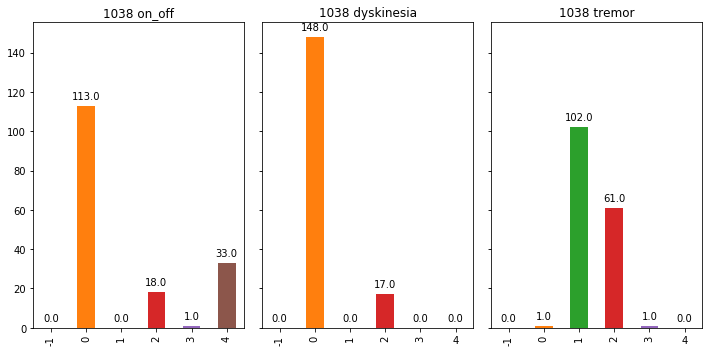

1038_test_kfold_0.csv
Nb subject_id :  1


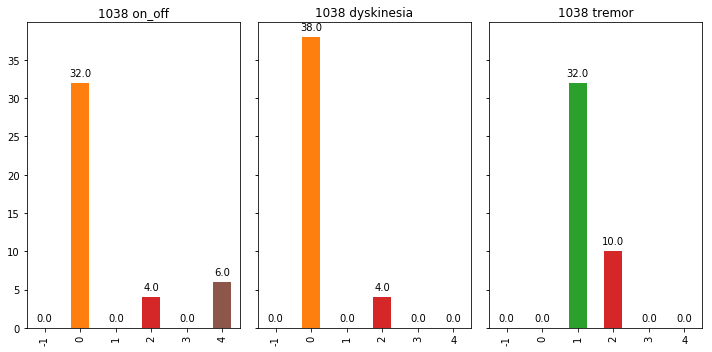

In [48]:
data_type = "cis"
data_real_subtype=""

if data_type == "cis":
    kfold_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.k_fold_v1/"

data_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
data_path = data_path + data_type + "-pd.training_data/" + data_real_subtype + "/"

nb_folds = np.array([0,1,2,3,4])
nb_folds = np.array([0])

pids = np.array([1004,1006,1007,1019,1020,1023,1032,1034,1038,1039,1043,1044,1046,1048,1049,1051])
pids = np.array([1038])

for temp_pid in pids:
    for nb in nb_folds:
        for train_or_test in ['train','test']:
            file_name = str(temp_pid) + '_'+train_or_test+'_kfold_' + str(nb) + '.csv'
            print(file_name)
            df_train_label = pd.read_csv(kfold_path+file_name)
            
            # Compute the occurences of each symptoms for each patient
            df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
                df_train_label=df_train_label
            )

            # Plot the graphs
            plot_symptoms_occurences(
                df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
            )

            #print(df_train_label.values[:,1:])
            #temp_train_X = pd.read_csv(data_path+df_train_label["measurement_id"][idx] + '.csv')

## Histograms - ALL FOLDS - True Labels

1038_train_kfold_0.csv
1038_train_kfold_1.csv
1038_train_kfold_2.csv
1038_train_kfold_3.csv
1038_train_kfold_4.csv
Nb subject_id :  1


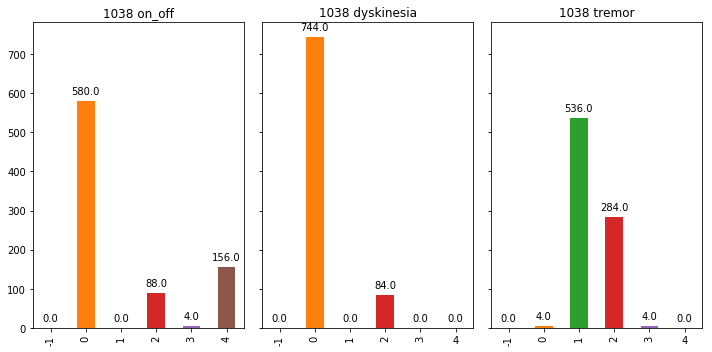

1038_test_kfold_0.csv
1038_test_kfold_1.csv
1038_test_kfold_2.csv
1038_test_kfold_3.csv
1038_test_kfold_4.csv
Nb subject_id :  1


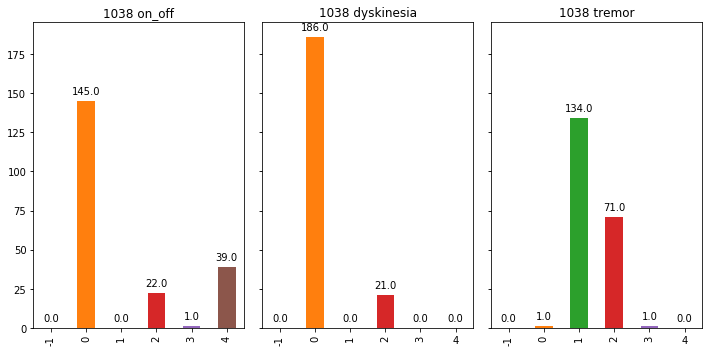

In [41]:
data_type = "cis"
data_real_subtype=""

kfold_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.k_fold_v3/"

data_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
data_path = data_path + data_type + "-pd.training_data/" + data_real_subtype + "/"

nb_folds = np.array([0,1,2,3,4])
# nb_folds = np.array([0,1,2,3,4])

pids = np.array([1004,1006,1007,1019,1020,1023,1032,1034,1038,1039,1043,1044,1046,1048,1049,1051])
pids = np.array([1038])



for temp_pid in pids:
    for train_or_test in ['train','test']:
        
        glob_df_train_label = pd.DataFrame()
        
        for nb in nb_folds:
            file_name = str(temp_pid) + '_'+train_or_test+'_kfold_' + str(nb) + '.csv'
            print(file_name)
            
            df_train_label = pd.read_csv(kfold_path+file_name)
            glob_df_train_label = glob_df_train_label.append(df_train_label)

#         print(glob_df_train_label)
        
        # Compute the occurences of each symptoms for each patient
        df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
            df_train_label=glob_df_train_label
        )

        # Plot the graphs
        plot_symptoms_occurences(
            df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
        )


In [88]:
df_occurences, df_train_label_subject_id

(    subject_id     symptom  symptom_value  occurence
 0         1004      on_off            1.0          7
 1         1004      on_off            3.0          5
 2         1004      on_off            2.0          4
 3         1004      on_off            0.0          1
 4         1004  dyskinesia            1.0          7
 5         1004  dyskinesia            3.0          5
 6         1004  dyskinesia            2.0          4
 7         1004  dyskinesia            0.0          1
 8         1004      tremor            1.0          7
 9         1004      tremor            3.0          5
 10        1004      tremor            2.0          4
 11        1004      tremor            0.0          1,
 <pandas.core.groupby.groupby.DataFrameGroupBy object at 0x7f4687701550>)

### Bar plots of the training labels 

In [ ]:
def plot_bar_labels(data_path, sFileName, sSubchallenge, plot_title):
    """
    Plot a bar graph according to the csv file passed in parameters
    
    Keyword Arguments:
    - TODO 
    """
    df_train_predictions = pd.read_csv(data_path+sFileName)

    df_train_predictions_reorder = df_train_predictions[sSubchallenge].round().value_counts(sort=True)
    order = [-1,0,1,2,3,4]
    df_train_predictions_reorder = df_train_predictions_reorder.reindex(order)

    ax = df_train_predictions_reorder.plot('bar')

    plt.title(plot_title)
    plt.xlabel("Label",fontsize=15)
    plt.ylabel("Frequency",fontsize=15)

    add_value_labels(ax)

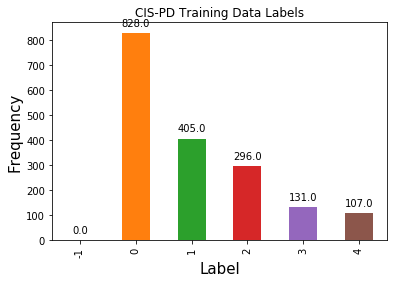

In [131]:
data_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.data_labels/"
sFileName = "CIS-PD_Training_Data_IDs_Labels.csv"
sSubchallenge = "on_off"
plot_title ="CIS-PD Training Data Labels"

plot_bar_labels(data_path, sFileName, sSubchallenge, plot_title)

### Histo of the predictions 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
----- 1004----- 
Using SVR
Training R2:  0.991391534985327
Testing R2:  -0.18463733564757234
TRAIN NEW R2 SCORE :  0.9913915349853268
TEST NEW R2 SCORE :  -0.18463733564757234
Training MSE :  0.009335055032288575
Testing MSE :  1.6604611962262372
----- 1006----- 
Using SVR
Training R2:  0.9467308037781805
Testing R2:  -0.06528368172508481
TRAIN NEW R2 SCORE :  0.9467308037781805
TEST NEW R2 SCORE :  -0.06528368172508481
Training MSE :  0.009987974291591149
Testing MSE :  0.49976271488337315
----- 1007----- 
Using SVR
Training R2:  0.9932959607515677
Testing R2:  -0.0051404135536674556
TRAIN NEW R2 SCORE :  0.9932959607515677
TEST NEW R2 SCORE :  -0.0051404135536674556
Training MSE :  0.00969213889217901
Testing MSE :  1.4837345101272361
----- 1019----- 
Using SVR
Training R2:  0.9953148671117785
Testing R2:  0.1656537157227541
TRAIN NEW R2 SCORE :  0.9953148671117785
TEST NEW R2 SCORE :  0.165653715

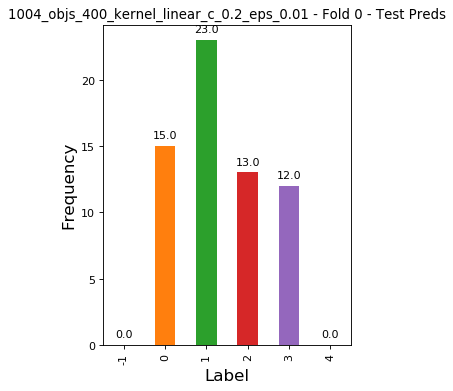

----- 1004----- 
Using SVR
Training R2:  0.9920853049080931
Testing R2:  -0.6943214611931345
TRAIN NEW R2 SCORE :  0.9920853049080931
TEST NEW R2 SCORE :  -0.6943214611931345
Training MSE :  0.009471407901699693
Testing MSE :  1.7822620214626745
----- 1006----- 
Using SVR
Training R2:  0.9646459483239584
Testing R2:  -0.038446529964756504
TRAIN NEW R2 SCORE :  0.9646459483239584
TEST NEW R2 SCORE :  -0.038446529964756504
Training MSE :  0.010005070509985598
Testing MSE :  0.19470872436839184
----- 1007----- 
Using SVR
Training R2:  0.9932235057954125
Testing R2:  0.10017222487392362
TRAIN NEW R2 SCORE :  0.9932235057954125
TEST NEW R2 SCORE :  0.10017222487392363
Training MSE :  0.009774952879906667
Testing MSE :  1.3394120071073101
----- 1019----- 
Using SVR
Training R2:  0.9952569475548563
Testing R2:  -0.06961186738495795
TRAIN NEW R2 SCORE :  0.9952569475548564
TEST NEW R2 SCORE :  -0.06961186738495795
Training MSE :  0.00988135926071594
Testing MSE :  2.403325430420523
----- 1020-

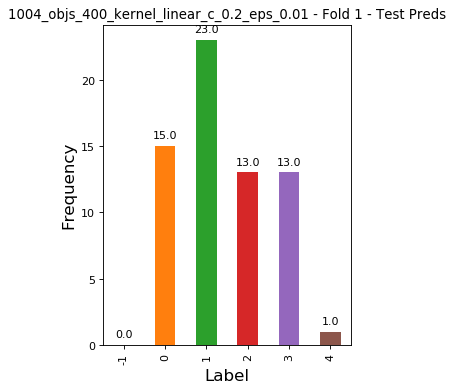

----- 1004----- 
Using SVR
Training R2:  0.9917161966406989
Testing R2:  -0.041876232959803694
TRAIN NEW R2 SCORE :  0.9917161966406989
TEST NEW R2 SCORE :  -0.041876232959803694
Training MSE :  0.00980516302124812
Testing MSE :  1.135482300764786
----- 1006----- 
Using SVR
Training R2:  0.9638772323368164
Testing R2:  0.06278924904515515
TRAIN NEW R2 SCORE :  0.9638772323368163
TEST NEW R2 SCORE :  0.06278924904515515
Training MSE :  0.009993965720147492
Testing MSE :  0.1912675001948663
----- 1007----- 
Using SVR
Training R2:  0.9932162070014011
Testing R2:  -0.03663864170422437
TRAIN NEW R2 SCORE :  0.9932162070014011
TEST NEW R2 SCORE :  -0.03663864170422437
Training MSE :  0.009785481239466548
Testing MSE :  1.5430577740673852
----- 1019----- 
Using SVR
Training R2:  0.9951994782840196
Testing R2:  0.027590096918350012
TRAIN NEW R2 SCORE :  0.9951994782840196
TEST NEW R2 SCORE :  0.027590096918350016
Training MSE :  0.010001086908292598
Testing MSE :  2.1849210168007445
----- 1020

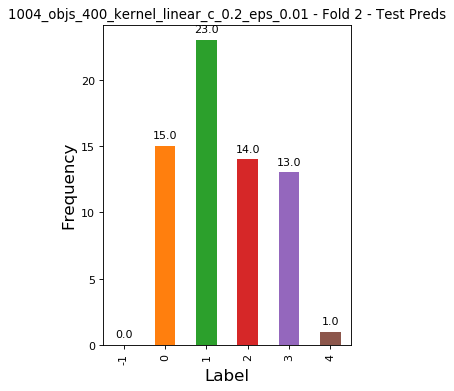

----- 1004----- 
Using SVR
Training R2:  0.9916818590201234
Testing R2:  -0.5728952712954081
TRAIN NEW R2 SCORE :  0.9916818590201234
TEST NEW R2 SCORE :  -0.5728952712954081
Training MSE :  0.00984580690822864
Testing MSE :  1.714210080825855
----- 1006----- 
Using SVR
Training R2:  0.9638858051205853
Testing R2:  0.19948811393154753
TRAIN NEW R2 SCORE :  0.9638858051205852
TEST NEW R2 SCORE :  0.19948811393154753
Training MSE :  0.009991593916638104
Testing MSE :  0.1633697726670311
----- 1007----- 
Using SVR
Training R2:  0.9933652004599605
Testing R2:  -0.0010797570481386742
TRAIN NEW R2 SCORE :  0.9933652004599604
TEST NEW R2 SCORE :  -0.0010797570481386742
Training MSE :  0.009566467787487432
Testing MSE :  1.4945045232493865
----- 1019----- 
Using SVR
Training R2:  0.9952191495379817
Testing R2:  0.033294954869107274
TRAIN NEW R2 SCORE :  0.9952191495379819
TEST NEW R2 SCORE :  0.033294954869107274
Training MSE :  0.00996010512920454
Testing MSE :  2.1721026939978088
----- 1020-

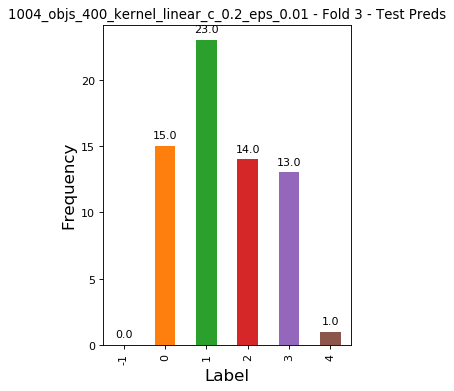

----- 1004----- 
Using SVR
Training R2:  0.9915295346962096
Testing R2:  -0.5382060159270126
TRAIN NEW R2 SCORE :  0.9915295346962097
TEST NEW R2 SCORE :  -0.5382060159270126
Training MSE :  0.010000058411200443
Testing MSE :  1.6951658134705851
----- 1006----- 
Using SVR
Training R2:  0.9646787884799806
Testing R2:  -0.16693265950128966
TRAIN NEW R2 SCORE :  0.9646787884799807
TEST NEW R2 SCORE :  -0.16693265950128966
Training MSE :  0.009997262781940967
Testing MSE :  0.16207398048629024
----- 1007----- 
Using SVR
Training R2:  0.9934665287304557
Testing R2:  -0.13903364059186707
TRAIN NEW R2 SCORE :  0.9934665287304556
TEST NEW R2 SCORE :  -0.13903364059186707
Training MSE :  0.009712184212627045
Testing MSE :  1.472655919936822
----- 1019----- 
Using SVR
Training R2:  0.9956019263559752
Testing R2:  -0.1418672554868794
TRAIN NEW R2 SCORE :  0.9956019263559752
TEST NEW R2 SCORE :  -0.1418672554868794
Training MSE :  0.009637853127884892
Testing MSE :  1.9269009936341088
----- 1020--

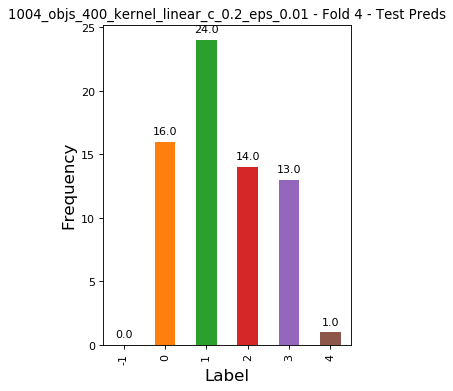

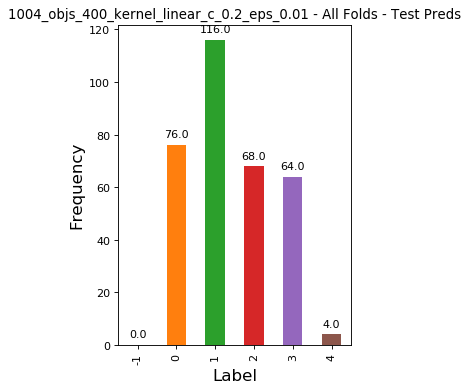

In [51]:
%load_ext autoreload
%autoreload 2
from pca_knn_bpd2 import *

def plot_bar_predictions_(df_predictions, plot_title):
    """
    Plot a bar graph according to the csv file passed in parameters
    
    Keyword Arguments:
    - TODO 
    """

    df_predictions_reorder = df_predictions.round().value_counts(sort=True)
    order = [-1,0,1,2,3,4]
    df_predictions_reorder = df_predictions_reorder.reindex(order)
    plt.figure(figsize=(5,5), dpi=80)
    ax = df_predictions_reorder.plot('bar')

    plt.title(plot_title)
    plt.xlabel("Label",fontsize=15)
    plt.ylabel("Frequency",fontsize=15)
#     plt.figure(figsize=(30,15))
#     plt.figure(figsize=(20,10))
    add_value_labels(ax)
    plt.tight_layout()
    plt.show()

import pickle

pid = "1004"

glob_test_pred = []

for fold in [0,1,2,3,4]:
    sFileTrai="/export/c08/lmorove1/kaldi/egs/beatPDivec/on_off_noinact_auto30_320fl/exp/ivec_550/ivectors_Training_Fold"+str(fold)+"/ivector.scp"
    sFileTest="/export/c08/lmorove1/kaldi/egs/beatPDivec/on_off_noinact_auto30_320fl/exp/ivec_550/ivectors_Testing_Fold"+str(fold)+"/ivector.scp"
    iComponents=400

    sOut="/home/mpgill/BeatPD/BeatPD-CLSP-JHU/ResiVecSVR_Fold"+str(fold)+"/"

    iNeighbors=None

    vTraiPCA, vLTrai, vTraiSubjectId, vTraiMeasurementId, vTestPCA, vLTest, vTestSubjectId, vTestMeasurementId = pca(sFileTrai, sFileTest, iComponents)

    pca_knn_bpd2(sFileTrai, sFileTest, sOut, iComponents, iNeighbors, sKernel='linear', fCValue=0.2, fEpsilon='0.1')


    fold_folder = "/home/mpgill/BeatPD/BeatPD-CLSP-JHU/ResiVecSVR_Fold"+str(fold)+"/"
    sFileName = pid+"_objs_400_kernel_linear_c_0.2_eps_0.1.pkl"

    [predictionsTrai,vLTrai_subjectid,predictions,vLTest_subjectid, vTraiMeasurementId, \
     mse_trai_subjectid, \
     mse_test_subjectid, \
     lTestMeasId_subjectid] = pickle.load(open(fold_folder+sFileName, "rb" ) )
    
    glob_test_pred=np.append(glob_test_pred,predictionsTrai,axis=0)
#     print(predictionsTrai.round().astype(int))
#     print(vLTrai_subjectid)
#     print("EQUAL? : ", predictionsTrai.round().astype(int) == vLTrai_subjectid)
    
    print(predictions)
    print(vLTest_subjectid)
    print("EQUAL? : ", predictions.round().astype(int) == vLTest_subjectid)
    
    # Plot per fold 
    plot_bar_predictions_(pd.Series(predictionsTrai), (pid+"_objs_400_kernel_linear_c_0.2_eps_0.01 - Fold "+str(fold)+" - Test Preds"))

plot_bar_predictions_(pd.Series(glob_test_pred), (pid+"_objs_400_kernel_linear_c_0.2_eps_0.01 - All Folds - Test Preds"))
#     do_confusion_matrix(y_test=vLTest_subjectid, predictions=predictions.round().astype(int))
# plt.close('all')

### Bar Plot of Predictions for all folds, all patients 

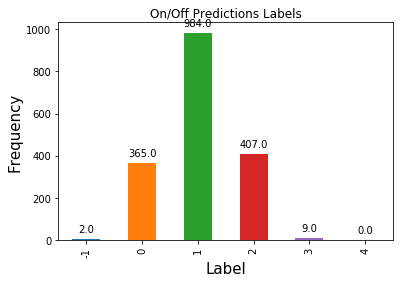

In [128]:
data_path = "/export/c08/lmorove1/kaldi/egs/beatPDivec/on_off_noinact_auto30/exp/ivec_450/resiVecSVR_Fold_all/"
sFileName = "objs_400_kernel_linear_c_0.2_eps_0.1.csv"
sSubchallenge = "on_off"
plot_title ="On/Off Predictions Labels"

plot_bar_labels(data_path, sFileName, sSubchallenge, plot_title)

In [ ]:
# print(df_train_label.round())

data_path = "/export/c08/lmorove1/kaldi/egs/beatPDivec/trem_noinact_auto30/exp/ivec_450/resiVecSVR_Fold_all/"
sFileName = "objs_450_kernel_linear_c_0.02_eps_0.1.csv"
df_train_label_trem = pd.read_csv(data_path+sFileName)

data_path = "/export/c08/lmorove1/kaldi/egs/beatPDivec/v1_dysk_auto/exp/ivec_500/resiVecSVR_Fold/"
sFileName = "Dyskinesia_testing.csv"
df_train_label_dysk = pd.read_csv(data_path+sFileName)

### Analyze the kfold distribution V2

In [ ]:
data_type = "cis"
data_real_subtype=""

if data_type == "cis":
    kfold_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.k_fold_v2/"

data_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
data_path = data_path + data_type + "-pd.training_data/" + data_real_subtype + "/"

nb_folds = np.array([0,1,2,3,4])

pids = np.array([1038])
#pids = np.array([1004,1006,1007,1019,1020,1023,1032,1034,1038,1039,1043,1044,1046,1048,1049,1051])

for temp_pid in pids:
    for nb in nb_folds:
        for train_or_test in ['train','test']:
            file_name = str(temp_pid) + '_'+train_or_test+'_kfold_' + str(nb) + '.csv'
            print(file_name)
            df_train_label = pd.read_csv(kfold_path+file_name)
            # Compute the occurences of each symptoms for each patient

            df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
                df_train_label=df_train_label
            )

            # Plot the graphs
            plot_symptoms_occurences(
                df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
            )

            #print(df_train_label.values[:,1:])
            #temp_train_X = pd.read_csv(data_path+df_train_label["measurement_id"][idx] + '.csv')

# CIS Database

## Distribution of the length of the files

path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/


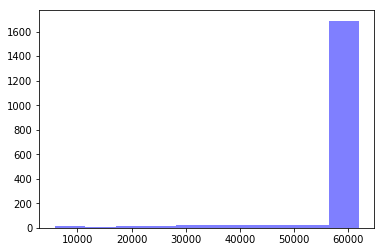

min :  5803
max :  61960


In [9]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

data_type = "cis"

path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary,
                                                   data_real_subtype)
len_distribution = []
for idx in df_train_label.index:
        df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
        len_distribution.append(len(df_train_data))


num_bins = 10
n, bins, patches = plt.hist(len_distribution, num_bins, facecolor='blue', alpha=0.5)
plt.show()

print('min : ', min(len_distribution))
print('max : ', max(len_distribution))

### Remove activity with pct_change and plot the accelerometer after

In [ ]:
data_type = "cis"
data_dir = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
path_save_accelerometer_plots = "/home/sjoshi/codes/python/BeatPD/code/accelerometer_plots/"
training_or_ancillary='training_data'

path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)

list_measurement_id = ["5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a"]

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label,
                                      list_measurement_id=list_measurement_id)

plot_accelerometer(df_train_label=df_train_label,
                   data_type=data_type,
                   path_train_data=path_train_data,
                   path_accelerometer_plots=path_save_accelerometer_plots)

path_no_inactivity_data = remove_inactivity_pct_change(df_train_label,
                                                       data_dir,
                                                       path_train_data,
                                                       data_type)

# Plot the accelerometer data
plot_accelerometer(df_train_label=df_train_label,
                   data_type=data_type,
                   path_train_data=path_train_data,
                   path_accelerometer_plots=path_save_accelerometer_plots,
                   path_inactivity=path_no_inactivity_data)

### How to print accelerometers before/after and write a wav file for 1 file 

In [ ]:
data_type = "cis"
path_save_accelerometer_plots = "/home/sjoshi/codes/python/BeatPD/code/accelerometer_plots/"
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary,
                                                   data_real_subtype)

list_measurement_id = ['db2e053a-0fb8-4206-891a-6f079fb14e3a']


df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

# Plot the accelerometer data
plot_accelerometer(data_type=data_type, path_accelerometer_plots=path_save_accelerometer_plots)

remove_inactivity_highpass(
    df_train_label,
    energy_threshold=10,
    duration_threshold=3000,
    plot_frequency_response=True,
    plot_accelerometer_after_removal=True,
    mask_path='/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/')


# Apply filter 
for idx in df_train_label.index:
    df_train_data = apply_mask(df_train_label["measurement_id"][idx],
                               mask_path='/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/')
    print('len : ', len(df_train_data))
    great_title = get_plot_title(idx, df_train_label)
    
    print('AFTER REMOVAL')
    #Plot accelerometer 
    print('len : ', len(df_train_data))
    x_axis_data_type = "t" if data_type == "real" else "Timestamp"
    df_train_data.plot(
                    x=x_axis_data_type, legend=True, subplots=True, title=great_title
                )
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

# REAL-PD Database

In [ ]:
data_type = "real"
data_real_subtype = 'smartphone_accelerometer'
training_or_ancillary='training_data' #training_data
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary,
                                                   data_real_subtype)

list_measurement_id=['b50d1b0c-2cd1-45f8-9097-0742e5cbbcc8']

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)


# Compute the occurences of each symptoms for each patient
df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
    df_train_label=df_train_label
)

# Plot the graphs
plot_symptoms_occurences(
    df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
)

## Distribution of the length of the files

In [ ]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

data_type = "real"
training_or_ancillary='training_data'
data_real_subtype='smartphone_accelerometer'

for data_real_subtype in ['smartphone_accelerometer','smartwatch_accelerometer','smartwatch_gyroscope']:
    path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary,
                                                   data_real_subtype)
    len_distribution = []

    for idx in df_train_label.index:
        try:
            df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
            len_distribution.append(len(df_train_data))
        except FileNotFoundError:
            continue
    print(data_real_subtype)
    num_bins = 10
    n, bins, patches = plt.hist(len_distribution, num_bins, facecolor='blue', alpha=0.5)
    plt.show()


# Confusion Matrix

In [9]:
def do_confusion_matrix(y_test, predictions):
    print('y test : ', np.unique(y_test))
    LABELS_NEW = np.unique(y_test)
    n_classes=np.unique(y_test)
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, predictions)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)

    # Plot Results:
    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix,
        interpolation='nearest',
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS_NEW, rotation=90)
    plt.yticks(tick_marks, LABELS_NEW)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()